### Exploratory Data Analysis
In this notebook, we will explore our data to get a better sense of it. One of the key considerations of this project is that we are building a recommender system which has some facets that are slightly different than a typical "predictive" model. As such, we should be cognizant that some of our exploration should help us understand our data from a recommender system perspective as well.

In [1]:
#First, let's import that relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Next let's import out data
ratings_df_complete = pd.read_csv('Ratings_Table_COMPLETE.csv')

#Check that everything looks okay
ratings_df_complete.head(10)

,Unnamed: 0,user_id,movie_id,rating,timestamp,movie_title
0,0,0,172,5,881250949,"Empire Strikes Back, The (1980)"
1,1,0,133,1,881250949,Gone with the Wind (1939)
2,2,196,242,3,881250949,Kolya (1996)
3,3,186,302,3,891717742,L.A. Confidential (1997)
4,4,22,377,1,878887116,Heavyweights (1994)
5,5,244,51,2,880606923,Legends of the Fall (1994)
6,6,166,346,1,886397596,Jackie Brown (1997)
7,7,298,474,4,884182806,Dr. Strangelove or: How I Learned to Stop Worr...
8,8,115,265,2,881171488,"Hunt for Red October, The (1990)"
9,9,253,465,5,891628467,"Jungle Book, The (1994)"


In [3]:
#We'll drop the Unnamed: 0 column simplybecause it is a repeat of the index and is an artifact of loading the data
ratings_df_complete.drop(['Unnamed: 0'],axis=1, inplace= True)

In [4]:
#Let's get a sense of our "complete" DataFrame as is currently
ratings_df_complete.describe()

,user_id,movie_id,rating,timestamp
count,100002.000000,100002.000000,100002.000000,1.000020e+05
mean,462.475500,425.524670,3.529849,8.835288e+08
std,266.619776,330.797313,1.125700,5.343812e+06
min,0.000000,1.000000,1.000000,8.747247e+08
25%,254.000000,175.000000,3.000000,8.794487e+08
50%,447.000000,322.000000,4.000000,8.828269e+08
75%,682.000000,631.000000,4.000000,8.882600e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


In [5]:
#Let's get a sense of our "complete" DataFrame as is currently
ratings_df_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100002 entries, 0 to 100001
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      100002 non-null  int64 
 1   movie_id     100002 non-null  int64 
 2   rating       100002 non-null  int64 
 3   timestamp    100002 non-null  int64 
 4   movie_title  100002 non-null  object
dtypes: int64(4), object(1)
memory usage: 3.8+ MB


We can see here that we have a total of 10,002 observations to work with, which should give us a fairly good amount of data to work with even if we end up having to drop some observations. It's important to remember though that one of the critical aspects of a rating system that works solely on collaborative filtering (i.e., basing predictive ratings on users that have made a rating) the amount of ratings per movie becomes critical because we need enough movies to develop a methodology to conduct ratings.  Thus, a pretty simply measure to consider is how many ratings each movie has as as starting point to consider how "sparse" or "dense" our data may be for any given movie.

In [6]:
#Setup a table to see how many ratings each movie got
movieId_RatingsCount = ratings_df_complete[['movie_id','rating']].groupby('movie_id').count()

#Check the table to make sure it makes sense
#movieId_RatingsCount.head()

In [7]:
#Let's get some summary data for our table here
movieId_RatingsCount.describe()

,rating
count,1682.000000
mean,59.454221
std,80.386954
min,1.000000
25%,6.000000
50%,27.000000
75%,80.000000
max,583.000000


Off the bat we can see that there is at least one movie that only have a single rating which we'll need to consider when we build our model. If there is only a single rating in the data, it means we will have no real way to test how good a recommendation is for that move (since we'd only have one training observation with no ability to evaluate on a test observation). One consideration that may make sense is we can simply drop movies with a single rating and explain to the sponsor that we'd need more ratings to make a meaningful prediction. This may also be an indication that the sponsor should consider how to get some more ratings for movies that typically do not get rated. However, we see that at the 25th percentile, we have a 6 which means at least 75% of our data has 6 or more ratings, which gives us at least some confidence that we can make some ratings (with the understanding that the strength of a prediction and our ability to generate meaningful predications may be predicated on how many observations we have)

In [8]:
#Let's make a list of the ratings count in descending order
RatingsCountList = list(movieId_RatingsCount.rating.sort_values(ascending = False))

#Make sure it makes sense
#print(RatingsCountList[0:5])
#print(len(RatingsCountList))

#Create a filler index
fillerIndex = list(range(0,len(RatingsCountList)))

#Crate a DataFrame so we can create an area plot
RatingsCount_df = pd.DataFrame({'movie_index':fillerIndex, 'ratings_count':RatingsCountList})

<AxesSubplot:ylabel='Number or Ratings'>

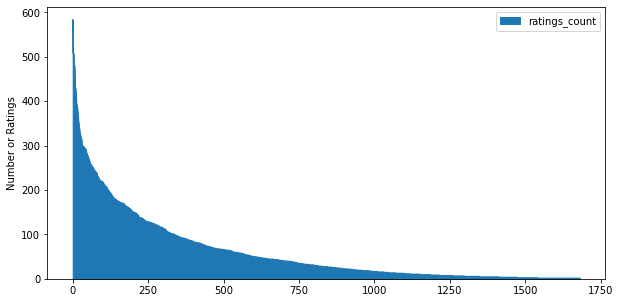

In [9]:
RatingsCount_df.plot.area(y='ratings_count', figsize = (10,5), ylabel='Number or Ratings')

Let's get a numeric count of the number of movies that only have a single movie to get a better sense of the number of observations that fall into this category.

In [10]:
#Let's get the count of number of movies with only a single rating
print(movieId_RatingsCount.loc[movieId_RatingsCount.rating == 1].count())

rating    141
dtype: int64


In [11]:
#Let's get the count of number of movies with only a single rating
print(movieId_RatingsCount.loc[movieId_RatingsCount.rating == 2].count())

rating    68
dtype: int64


In [12]:
#Let's get the count of number of movies with only a single rating
print(movieId_RatingsCount.loc[movieId_RatingsCount.rating == 3].count())

rating    60
dtype: int64


In [13]:
#Let's get the count of number of movies with only a single rating
print(movieId_RatingsCount.loc[movieId_RatingsCount.rating == 4].count())

rating    64
dtype: int64


One thing we'll need to consider is are the "corner" cases once we start modeling, but for now, this is more of an exploration. We see that 141 movies only have a single rating which means it will be difficult to generate any meanginful predictions from the data set in terms of a training and test set. We can consider how we want to handle a movie like this but given how we have a fair amount of other movies to work with, it may make sense to drop these observations. If we look at the number of movies with 4 or less movies, we get a total of 333 movies which is approximately 20% (333/1682) of our database which may be a little aggressive to drop. A consideration we'll have to make in the future is just how many ratings for a given movie is enough for us to built a model we are confident will do a decent job.

One final consideration we can make before moving to evaluating summary statistics is to get a sense of the counts of "ratings" per movie. Let's do this with a stacked area graph.

In [14]:
#Create a table that gives us the desired values.

#Step 1: Create a dataframe that holds all our unique movie id
holderMovieIDs = np.sort(ratings_df_complete.movie_id.unique())
#print(holderMovieIDs)

#Step 2: Create a DataFrame to populate
completeRatings_df = pd.DataFrame({'movie_id':holderMovieIDs, 'ones':0,'twos':0,'threes':0,'fours':0,'fives':0})
print(completeRatings_df)

      movie_id  ones  twos  threes  fours  fives
0            1     0     0       0      0      0
1            2     0     0       0      0      0
2            3     0     0       0      0      0
3            4     0     0       0      0      0
4            5     0     0       0      0      0
...        ...   ...   ...     ...    ...    ...
1677      1678     0     0       0      0      0
1678      1679     0     0       0      0      0
1679      1680     0     0       0      0      0
1680      1681     0     0       0      0      0
1681      1682     0     0       0      0      0

[1682 rows x 6 columns]


In [15]:
#Step 3: Create a cleaner subset of our main Dataframe to work with
ratingsVector = ratings_df_complete[['movie_id','rating']]
#print(type(ratingsVector))

#Step 4: Creat a loop that will populate our table appropriately
for counter in range (len(ratingsVector['rating'])):
    movID = ratingsVector.iloc[counter,0]
    movRate = ratingsVector.iloc[counter,1]
    if movRate == 1:
        completeRatings_df.loc[completeRatings_df.movie_id == movID,'ones'] = completeRatings_df.loc[completeRatings_df.movie_id == movID,'ones'] + 1
    elif movRate == 2:
        completeRatings_df.loc[completeRatings_df.movie_id == movID,'twos'] = completeRatings_df.loc[completeRatings_df.movie_id == movID,'twos'] + 1
    elif movRate == 3:
        completeRatings_df.loc[completeRatings_df.movie_id == movID,'threes'] = completeRatings_df.loc[completeRatings_df.movie_id == movID,'threes'] + 1
    elif movRate == 4:
        completeRatings_df.loc[completeRatings_df.movie_id == movID,'fours'] = completeRatings_df.loc[completeRatings_df.movie_id == movID,'fours'] + 1
    elif movRate == 5:
        completeRatings_df.loc[completeRatings_df.movie_id == movID,'fives'] = completeRatings_df.loc[completeRatings_df.movie_id == movID,'fives'] + 1
    else:
        print('Error')

In [16]:
#Check New Dataframe
#completeRatings_df.head()

In [17]:
#Step 5: Add one more column to get the count
completeRatings_df['total_count'] = 0
completeRatings_df.head()

,movie_id,ones,twos,threes,fours,fives,total_count
0,1,8,27,96,202,119,0
1,2,8,17,55,42,9,0
2,3,11,20,25,23,11,0
3,4,6,24,57,93,29,0
4,5,4,11,32,33,6,0


In [18]:
#Step 6: Sum across columns
completeRatings_df['total_count'] = completeRatings_df['ones'] + completeRatings_df['twos'] + completeRatings_df['threes'] + completeRatings_df['fours'] + completeRatings_df['fives']

In [19]:
#Check
completeRatings_df.head()

,movie_id,ones,twos,threes,fours,fives,total_count
0,1,8,27,96,202,119,452
1,2,8,17,55,42,9,131
2,3,11,20,25,23,11,90
3,4,6,24,57,93,29,209
4,5,4,11,32,33,6,86


In [20]:
#Sort by total_count
completeRatings_df_sorted = completeRatings_df.sort_values('total_count', ascending = False)
completeRatings_df_sorted.head()

,movie_id,ones,twos,threes,fours,fives,total_count
49,50,9,16,57,176,325,583
257,258,12,43,110,212,132,509
99,100,14,18,70,179,227,508
180,181,8,23,97,208,171,507
293,294,47,73,168,151,46,485


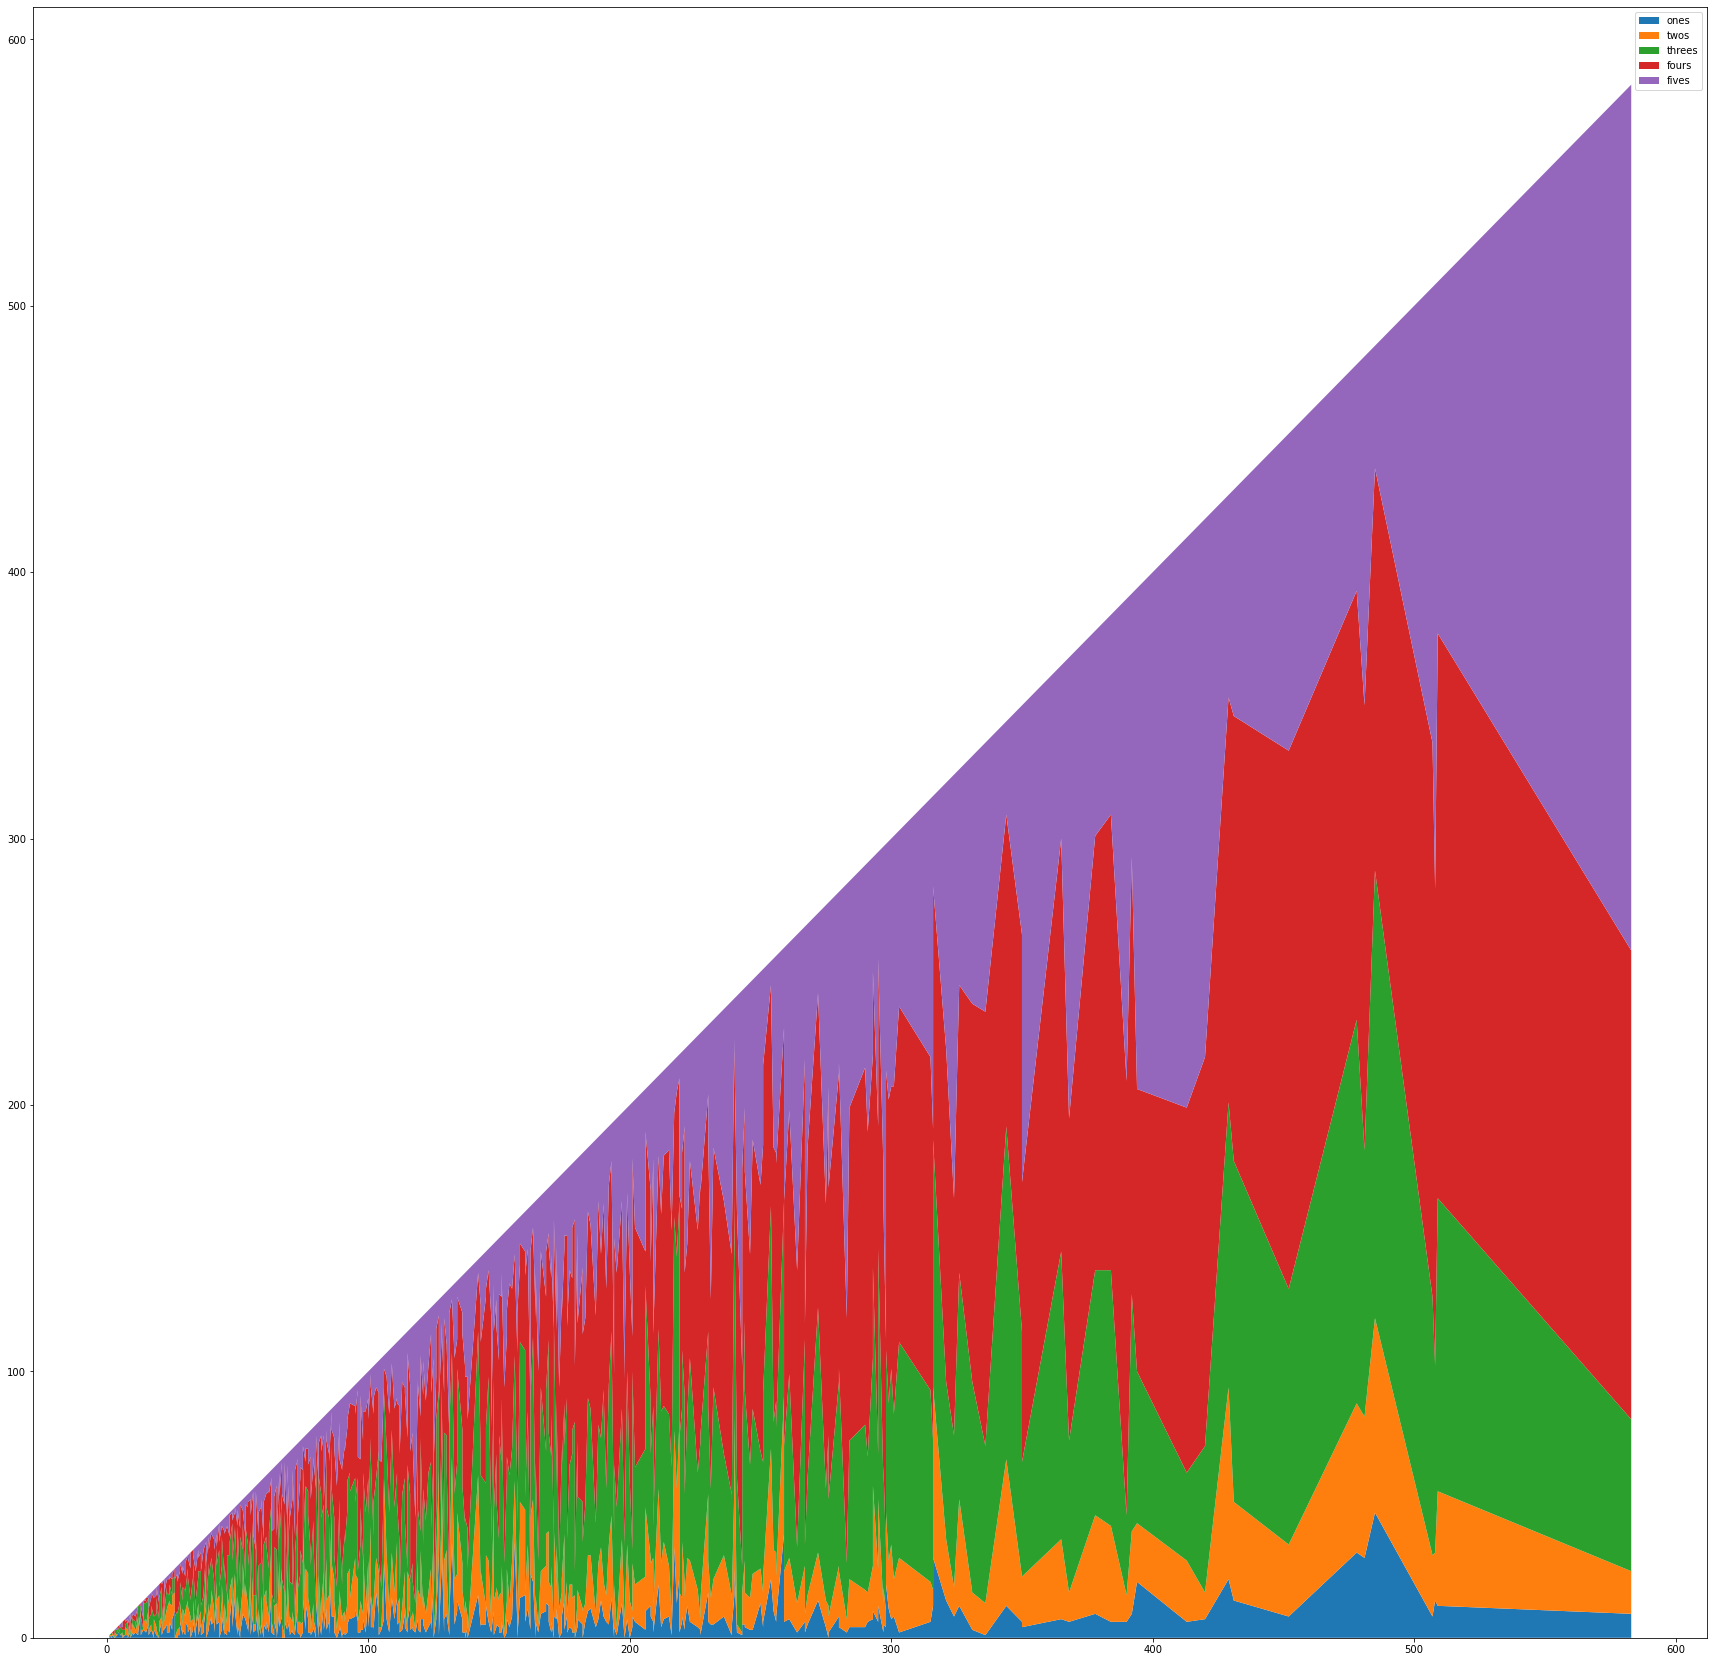

In [21]:
#Create a stacked area plot
plt.figure(figsize=(30,30))
plt.stackplot(completeRatings_df_sorted['total_count'],completeRatings_df_sorted['ones'],
             completeRatings_df_sorted['twos'], completeRatings_df_sorted['threes'],
             completeRatings_df_sorted['fours'],completeRatings_df_sorted['fives'])
plt.legend(['ones','twos','threes','fours','fives'])

The biggest thing we can see with this plot is that movies tend to have a a fair variable distribution of ones, twos, threes, and fours increasing as the number of ratings increase. The "five" category natural becomes more prevalent as the number of ratings increase especially once we hit the 500+ total ratings category.

Another aspect of movie ratings is the central tendency for a movie and the spread. This can give us an inclination regarding whether a movie rating tends to be quite central (i.e., imagine 100 people rate a movie and 50 of those people rate the movie a "3" while the other 50 rate the movie a "4") or can be quite divisive but result in a "middle" central tendency (i.e., imagine 100 people rate a movie and 50 of those people rate a movie a "1" and the other 50 rate the movie a "5") Thus, one thing we can consider is how summary statistics are spread amongst the ratings.

In [22]:
#Let's put this all together in a DataFrame that allows us to have everything organized nicely
holderRatingsCount = ratings_df_complete[['movie_id','rating']].groupby('movie_id').count()
holderRatingsCountValues = holderRatingsCount.rating

#Check
#print(holderRatingsValues[0:5])

In [23]:
#First, let's get the average rating grouped by movie.
holderRatingsAverage = ratings_df_complete[['movie_id','rating']].groupby('movie_id').mean()
holderRatingsAverageValues = holderRatingsAverage.rating

#Check
print(type(holderRatingsAverageValues))

<class 'pandas.core.series.Series'>


In [24]:
#Second, let's get the standard deviation rating grouped by movie.

#Step 1: Create intial data frame and set the column values equal to 0
holderRatingsStD = ratings_df_complete[['movie_id','rating']].groupby('movie_id').mean()
holderRatingsStD['rating'] = 0
#Step 1 is done to make sure we have the same size NP array since movies with a single rating will not have a Standard Deviation

#Step 2: Do the groupping values for Standard devaition
holderRatingsStDCalced = ratings_df_complete[['movie_id','rating']].groupby('movie_id').std()

#Step 3: Fill in the 'NaN' values with zero and pull out the values into a NP array
holderRatingsStDCalced = holderRatingsStDCalced.fillna(0)
holderRatingsStDCalced = holderRatingsStDCalced['rating']

In [25]:
#Let's combine all of this into a DataFrame

movie_idSummaryStats = pd.DataFrame({'movie_id':holderRatingsCountValues.index,
                                     'ratings_Count':holderRatingsCountValues.values,
                                     'ratings_Average':holderRatingsAverageValues.values,
                                     'ratings_Std':holderRatingsStDCalced.values})

#Check it works
movie_idSummaryStats.head()

,movie_id,ratings_Count,ratings_Average,ratings_Std
0,1,452,3.878319,0.927897
1,2,131,3.206107,0.966497
2,3,90,3.033333,1.212760
3,4,209,3.550239,0.965069
4,5,86,3.302326,0.946446


In [26]:
#Let's get a descritpion of our new Dataframe
movie_idSummaryStats.describe()

,movie_id,ratings_Count,ratings_Average,ratings_Std
count,1682.000000,1682.000000,1682.000000,1682.000000
mean,841.500000,59.454221,3.076036,0.968143
std,485.695893,80.386954,0.781653,0.405346
min,1.000000,1.000000,1.000000,0.000000
25%,421.250000,6.000000,2.659600,0.880659
50%,841.500000,27.000000,3.161528,1.012050
75%,1261.750000,80.000000,3.653428,1.154701
max,1682.000000,583.000000,5.000000,2.828427


This dataframe can also help us get a better sense of data with a scatterplot regarding how each movies ratings are organized.

<AxesSubplot:xlabel='ratings_Average', ylabel='ratings_Count'>

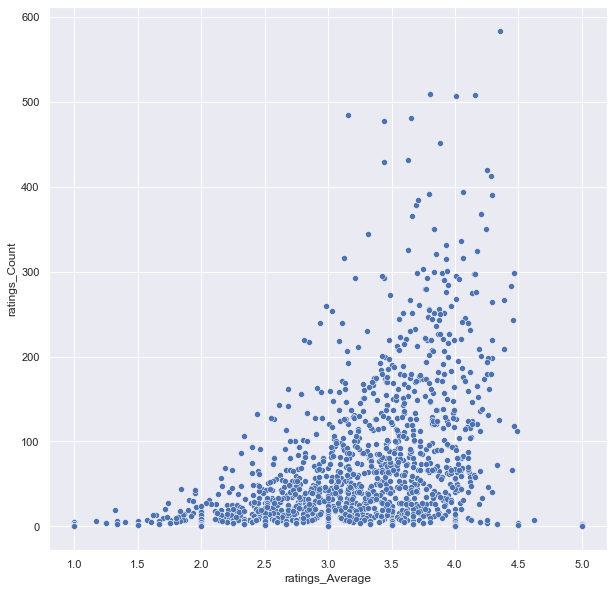

In [27]:
#Let's create a scatterplot that helps us visualize the information
sns.set(rc={"figure.figsize":(10,10)})
sns.scatterplot(data = movie_idSummaryStats, x = 'ratings_Average', y = 'ratings_Count')

One interesting thing this scatter plot shows us is that there is a tendency for movies with more views to get a higher rating, which makes sense. If a movie has "positive buzz" and is therefore more likely to be viewed positively, it would potentially draw more viewers and then get more ratings (most likely positive) as a result. If a movie is rated poorly, then it would dissuade others from watching it which would result in a suppression of ratings in terms of number of ratings. Thus, one thing we *could* consider when making our ratings is also just how many ratings a movie has received and how that may impact the score of a movie. Another facet we can consider is if we plot the average rating against standard deviation and bucket the points based on number of ratings

<AxesSubplot:xlabel='ratings_Average', ylabel='ratings_Std'>

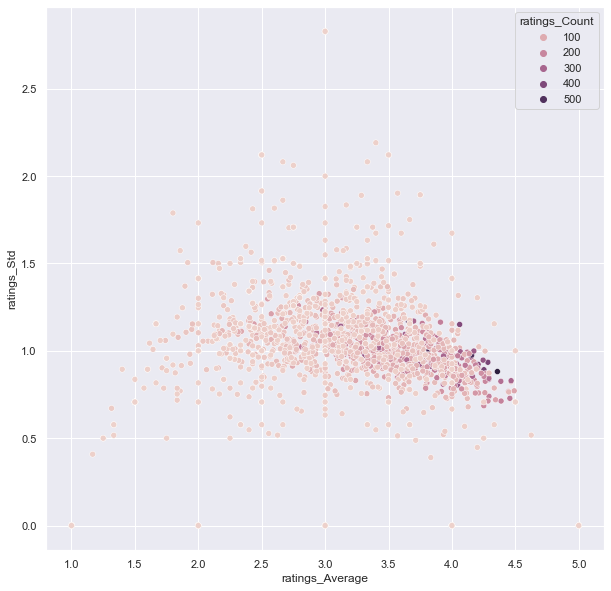

In [28]:
sns.set(rc={"figure.figsize":(10,10)})
sns.scatterplot(data = movie_idSummaryStats, x = 'ratings_Average', y = 'ratings_Std', hue = 'ratings_Count')

This graph also gives us another interesting trend that is somewhat expected due to the nature of the calculation of Standard Deviation. We see that there is a decrease in the Standard Deviation as ratings increase, which may be an artifact since for a variable with a fixed range (ratings can only be 1 at the lowest or 5 at highest), the more observations you have, the lower the total standard deviation will be. We can also test this by seeing how correlated the mean and standard deviation are.

In [29]:
#Make a simple correlation table
movie_idSummaryStats.corr()

,movie_id,ratings_Count,ratings_Average,ratings_Std
movie_id,1.000000,-0.633809,-0.394494,-0.209442
ratings_Count,-0.633809,1.000000,0.429654,0.056206
ratings_Average,-0.394494,0.429654,1.000000,0.160883
ratings_Std,-0.209442,0.056206,0.160883,1.000000


We can see that the correlation factor between Average and Std is rather low on a magnitude level (~0.16) so it would probably be safe to say we can't glean much from the Standard Deviation of the ratings of a movie in relation to predicting an average.

### Conclusion
We've explored our data a fair bit and got some useful information highlighted below:
* There is a correlation between number of ratings and the average rating of a movie
* We have a fair amount of movies with a single rating which may need to be dropped
* The standard deviation of the ratings tends to decrease with more movies (not surprising)

In the next notebook, we'll begin the pre-processinga and modeling process which may require us to consider how we want to measure certain features!